In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "SAP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn133781,MSSSSSSSSSSSQDGDGGNGRGGGRGGDFEGPSSSRRRAGDSNWPE...,150,1
1,Achn133791,MWYCPMLVVVKRMSLSLSEDKVCSTWRAVSRSDLLWLNLTRSIWNR...,397,1
2,Achn384971,MSSSSSQNGDGGNGRGRGRDFEGPSSSRRRAGGDNWPEPIVEALAS...,103,1
3,Achn384981,MYYQDILNPLLFDIPSSRRIKRRNGSQGIRIVLEDQKPRYRSFSCI...,408,1
4,AA503G00001,MSSSSSSSSDNGASRHGSRLFEAPSQSRPRRAANDVWPEPFLESLA...,449,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
280,0.002667,0.000000,0.000000,0.002667,0.000000,0.002667,0.000000,0.002667,0.005333,0.002667,...,0.000000,0.000000,0.000000,0.000000,0.008000,0.000000,0.000000,0.000000,0.002667,0.000000
201,0.027397,0.004566,0.013699,0.013699,0.004566,0.004566,0.004566,0.004566,0.004566,0.013699,...,0.000000,0.004566,0.000000,0.004566,0.004566,0.000000,0.009132,0.000000,0.000000,0.004566
127,0.008180,0.004090,0.004090,0.004090,0.004090,0.010225,0.002045,0.004090,0.002045,0.012270,...,0.000000,0.000000,0.000000,0.004090,0.004090,0.002045,0.002045,0.000000,0.000000,0.000000
267,0.002941,0.001471,0.001471,0.002941,0.004412,0.002941,0.002941,0.001471,0.000000,0.008824,...,0.001471,0.004412,0.001471,0.002941,0.004412,0.001471,0.001471,0.001471,0.000000,0.002941
178,0.013619,0.000000,0.000000,0.001946,0.003891,0.000000,0.001946,0.001946,0.001946,0.007782,...,0.000000,0.000000,0.000000,0.001946,0.003891,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (258, 437)
X_test: (65, 437)
y_train: (258,)
y_test: (65,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,393 (607.00 KB)

 Trainable params: 155,393 (607.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - accuracy: 0.5625 - loss: 0.6931

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5572 - loss: 0.6924 - val_accuracy: 0.5962 - val_loss: 0.6875


Epoch 2/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6562 - loss: 0.6890

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7257 - loss: 0.6866 - val_accuracy: 0.9615 - val_loss: 0.6773


Epoch 3/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.6775

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9572 - loss: 0.6744 - val_accuracy: 0.9808 - val_loss: 0.6602


Epoch 4/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.6608

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9955 - loss: 0.6554 - val_accuracy: 0.9808 - val_loss: 0.6332


Epoch 5/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.6314

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.6244 - val_accuracy: 0.9808 - val_loss: 0.5894


Epoch 6/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.5829

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9904 - loss: 0.5752 - val_accuracy: 1.0000 - val_loss: 0.5264


Epoch 7/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.5283

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9955 - loss: 0.5122 - val_accuracy: 1.0000 - val_loss: 0.4389


Epoch 8/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.4355

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.4130 - val_accuracy: 1.0000 - val_loss: 0.3314


Epoch 9/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.3375

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9923 - loss: 0.3077 - val_accuracy: 1.0000 - val_loss: 0.2157


Epoch 10/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.2204

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.1983 - val_accuracy: 1.0000 - val_loss: 0.1193


Epoch 11/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.1098

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.1006 - val_accuracy: 1.0000 - val_loss: 0.0606


Epoch 12/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0540

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0490 - val_accuracy: 1.0000 - val_loss: 0.0300


Epoch 13/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0231

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 0.0179


Epoch 14/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0164

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.0126


Epoch 15/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0079

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0118


Epoch 16/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0050

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0088



[Train Accuracy: 100.00% - Test Accuracy: 98.46%]


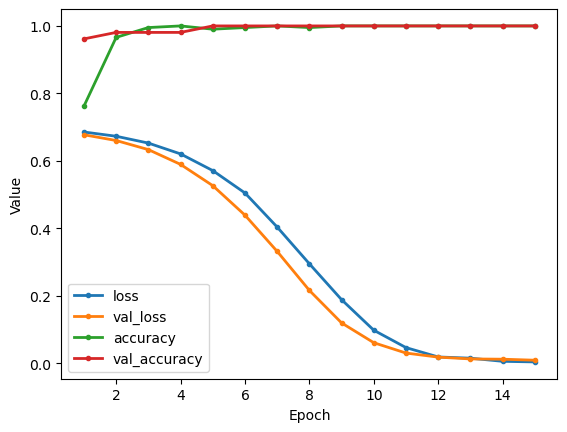

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYL,YYM,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYY
280,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
201,0.004587,0.0,0.004587,0.004587,0.0,0.0,0.0,0.004587,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.004587,0.0,0.0,0.0
127,0.000000,0.0,0.002049,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
267,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.001473,0.0,0.000000,...,0.001473,0.0,0.0,0.0,0.0,0.001473,0.000000,0.0,0.0,0.0
178,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.001949,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (258, 7856)
X_test: (65, 7856)
y_train: (258,)
y_test: (65,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,011,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,054,657 (7.84 MB)

 Trainable params: 2,054,657 (7.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step - accuracy: 0.5156 - loss: 0.6931

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5647 - loss: 0.6929 - val_accuracy: 0.7308 - val_loss: 0.6904


Epoch 2/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7656 - loss: 0.6906

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8125 - loss: 0.6888 - val_accuracy: 0.9808 - val_loss: 0.6796


Epoch 3/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.6790

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9848 - loss: 0.6757 - val_accuracy: 1.0000 - val_loss: 0.6605


Epoch 4/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.6597

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9923 - loss: 0.6537 - val_accuracy: 1.0000 - val_loss: 0.6255


Epoch 5/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.6222

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9923 - loss: 0.6154 - val_accuracy: 1.0000 - val_loss: 0.5740


Epoch 6/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.5717

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.5573 - val_accuracy: 1.0000 - val_loss: 0.4942


Epoch 7/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.4842

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.4669 - val_accuracy: 1.0000 - val_loss: 0.3834


Epoch 8/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.3883

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9955 - loss: 0.3640 - val_accuracy: 1.0000 - val_loss: 0.2581


Epoch 9/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.2547

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.2243 - val_accuracy: 1.0000 - val_loss: 0.1395


Epoch 10/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.1304

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.1113 - val_accuracy: 1.0000 - val_loss: 0.0621


Epoch 11/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0545

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0453 - val_accuracy: 1.0000 - val_loss: 0.0249


Epoch 12/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0207

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 1.0000 - val_loss: 0.0111


Epoch 13/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0096

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 0.0109



[Train Accuracy: 100.00% - Test Accuracy: 98.46%]


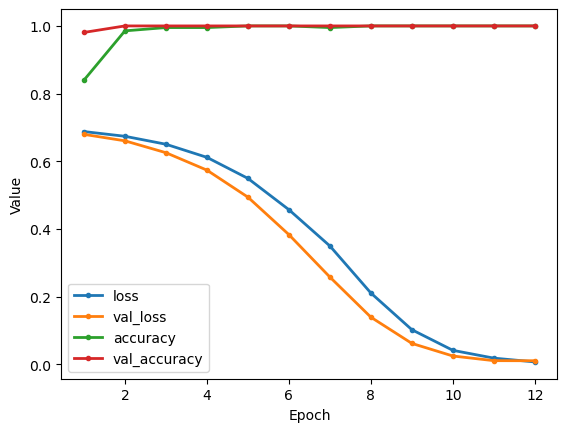

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYST,YYTA,YYTL,YYTT,YYVL,YYVP,YYYR,YYYT,YYYV,YYYY
280,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201,0.0,0.0,0.004608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      13,513,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,554,945 (51.71 MB)

 Trainable params: 13,554,945 (51.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step - accuracy: 0.4219 - loss: 0.6931

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4531 - loss: 0.6931 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4796 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6921


Epoch 2/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5156 - loss: 0.6910

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5069 - loss: 0.6910

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5100 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6881


Epoch 3/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4219 - loss: 0.6881

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4653 - loss: 0.6864

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4850 - loss: 0.6853 - val_accuracy: 0.5000 - val_loss: 0.6802


Epoch 4/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6875 - loss: 0.6727

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6892 - loss: 0.6713

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6951 - loss: 0.6704 - val_accuracy: 0.5192 - val_loss: 0.6653


Epoch 5/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9375 - loss: 0.6519

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9444 - loss: 0.6516

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9511 - loss: 0.6507 - val_accuracy: 0.9808 - val_loss: 0.6410


Epoch 6/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.6225

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.6195

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.6167 - val_accuracy: 1.0000 - val_loss: 0.6061


Epoch 7/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.5781

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.5687

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.5662 - val_accuracy: 1.0000 - val_loss: 0.5611


Epoch 8/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.5211

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.5051

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.5001 - val_accuracy: 1.0000 - val_loss: 0.4952


Epoch 9/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.4209

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.4082

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.4042 - val_accuracy: 1.0000 - val_loss: 0.4153


Epoch 10/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.3258

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.3109

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.3044 - val_accuracy: 1.0000 - val_loss: 0.3236


Epoch 11/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.2289

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.2117

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.2041 - val_accuracy: 1.0000 - val_loss: 0.2383


Epoch 12/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.1316

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.1196

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.1148 - val_accuracy: 1.0000 - val_loss: 0.1645


Epoch 13/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0795

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0667

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0622 - val_accuracy: 1.0000 - val_loss: 0.1090


Epoch 14/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0324

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0286

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0272 - val_accuracy: 1.0000 - val_loss: 0.0716


Epoch 15/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0127

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0128

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 0.0465


Epoch 16/100


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0076

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0074

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0330



[Train Accuracy: 100.00% - Test Accuracy: 98.46%]


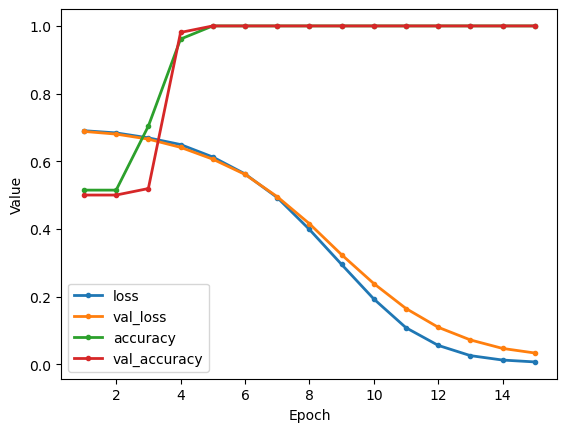

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [25]:
report.save()

Report saved as Output/Reports/SAP/report_SSJCMKLW.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################